# Ames Housing Dataset

## About Dataset
The Ames Housing Dataset is a well-known dataset in the field of machine learning and data analysis. It contains various features and attributes of residential homes in Ames, Iowa, USA. The dataset is often used for regression tasks, particularly for predicting housing prices.

### Key Details:
- **Number of Instances**: The dataset consists of 2,930 instances or observations.
- **Number of Features**: There are 79 different features or variables that describe various aspects of the residential properties.
- **Target Variable**: The target variable in the dataset is `SalePrice`, representing the sale price of the houses.
- **Data Types**:  
  - The features include both numerical and categorical variables.
  - They cover a wide range of aspects such as lot size, number of rooms, location, construction quality, and more.

### Applications:
The Ames Housing Dataset is widely used in the machine learning community for:
- **Regression Modeling**: Predicting house prices based on property features.
- **Feature Engineering**: Developing and testing new techniques to handle numerical and categorical data.
- **Predictive Analytics**: Analyzing and forecasting trends in the real estate domain.

This dataset serves as a valuable resource for exploring and applying machine learning algorithms to real-world problems related to housing prices.


# STEP 1: IMPORT LIBRARIES AND SETUP

In [1]:
# Standard Libraries
import os
import time
import logging

# Data Handling & Visualization Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Statistical Functions
from scipy.stats import skew

# Scikit-learn Libraries for Model Building & Evaluation
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    classification_report, confusion_matrix, ConfusionMatrixDisplay,
    mean_squared_error, mean_absolute_error, r2_score
)
from sklearn.preprocessing import PowerTransformer, StandardScaler, MinMaxScaler, PolynomialFeatures

# AWS & SageMaker Libraries for Model Training and Deployment
import boto3
import sagemaker
from sagemaker import Session, get_execution_role
from sagemaker.estimator import Estimator
from sagemaker.amazon.linear_learner import LinearLearner  # SageMaker's built-in Linear Learner algorithm
from sagemaker.inputs import TrainingInput
from sagemaker.predictor import Predictor
from sagemaker.serializers import CSVSerializer
from sagemaker.deserializers import JSONDeserializer
from sagemaker.tuner import HyperparameterTuner, IntegerParameter, ContinuousParameter

# Additional Libraries
from botocore.exceptions import ClientError
from typing import Any, List, Union

# Logger Setup
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

# Global Variables
file_path = "AmesHousing.csv"        # Path to the dataset file
original_target_col = "SalePrice"    # Name of the original target variable in the dataset


/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/pydantic/_internal/_fields.py:192: UserWarning: Field name "json" in "MonitoringDatasetFormat" shadows an attribute in parent "Base"
  warnings.warn(


[02/04/25 12:05:21] INFO     Found credentials from IAM Role:                                   ]8;id=420035;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/botocore/credentials.py\credentials.py]8;;\:]8;id=572944;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/botocore/credentials.py#1075\1075]8;;\
                             BaseNotebookInstanceEc2InstanceRole                                                   

sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/ec2-user/.config/sagemaker/config.yaml


# STEP 2: LOAD THE DATA

In [2]:
def load_data(filepath):
    """
    Load data from a CSV file into a pandas DataFrame.

    This function reads the CSV file at the given filepath using pandas' read_csv
    method. It is designed to illustrate basic data ingestion and includes error 
    handling for common issues, such as the file not being found. The error messages
    and exception re-raising help users diagnose problems during the loading process.

    Parameters:
        filepath (str): The path to the CSV file.

    Returns:
        pd.DataFrame: The DataFrame containing the loaded data.

    Raises:
        FileNotFoundError: If the file does not exist at the specified path.
        Exception: For any other error that occurs during the file reading.
    """
    try:
        # Attempt to read the CSV file into a DataFrame
        data = pd.read_csv(filepath)
        return data
    except FileNotFoundError as e:
        # Inform the user that the file was not found and re-raise the exception.
        print(f"Error: The file at '{filepath}' was not found.")
        raise e
    except Exception as e:
        # Handle any other exceptions that might occur during file reading.
        print(f"An error occurred while reading the file: {e}")
        raise e


# Define global variables for file path and target column for ease of modification.
file_path = "AmesHousing.csv"  # Path to the dataset file
target_col = "SalePrice"       # The column to be used as the target variable for prediction

# Load data using the load_data function.
df = load_data(file_path)
print("Data loaded successfully!\n")

# Display the first few rows of the dataset to provide a quick visual overview.
print("First five rows of the dataset:")
print(df.head())

# Display the dimensions of the dataset (number of rows and columns).
print("\nShape of the dataset:", df.shape)

# Print detailed information about the dataset, including data types and non-null counts.
print("\nDataset Info:")
df.info()


Data loaded successfully!

First five rows of the dataset:
   Order        PID  MS SubClass MS Zoning  Lot Frontage  Lot Area Street  \
0      1  526301100           20        RL         141.0     31770   Pave   
1      2  526350040           20        RH          80.0     11622   Pave   
2      3  526351010           20        RL          81.0     14267   Pave   
3      4  526353030           20        RL          93.0     11160   Pave   
4      5  527105010           60        RL          74.0     13830   Pave   

  Alley Lot Shape Land Contour  ... Pool Area Pool QC  Fence Misc Feature  \
0   NaN       IR1          Lvl  ...         0     NaN    NaN          NaN   
1   NaN       Reg          Lvl  ...         0     NaN  MnPrv          NaN   
2   NaN       IR1          Lvl  ...         0     NaN    NaN         Gar2   
3   NaN       Reg          Lvl  ...         0     NaN    NaN          NaN   
4   NaN       IR1          Lvl  ...         0     NaN  MnPrv          NaN   

  Misc Val Mo S

# STEP 3: PREPROCESS THE DATA

## Drop Columns with Too Many Missing Values

In [3]:
def drop_high_missing_columns(dataframe, threshold=0.3):
    """
    Drop columns from the DataFrame where the fraction of missing values exceeds the specified threshold.

    This function calculates the percentage of missing values in each column and removes
    those columns where the fraction of missing values is greater than the threshold. 
    This helps reduce noise and potential bias when features with too many missing values
    might negatively impact the model's performance.

    Parameters:
        dataframe (pd.DataFrame): The input DataFrame to process.
        threshold (float): The maximum allowable fraction of missing values for a column.
                           Columns exceeding this threshold will be dropped (default is 0.3).

    Returns:
        pd.DataFrame: A DataFrame with columns removed that have more than the allowed missing values.
    """
    # Identify columns where the proportion of missing values exceeds the threshold.
    cols_to_drop = dataframe.columns[dataframe.isnull().mean() > threshold]
    
    # Print out the columns that will be dropped for transparency.
    print(f"Dropping columns with more than {threshold*100:.0f}% missing values: {list(cols_to_drop)}")
    
    # Return a new DataFrame with the identified columns removed.
    return dataframe.drop(columns=cols_to_drop)


# Apply the function to the DataFrame to remove columns with too many missing values.
df = drop_high_missing_columns(df)


Dropping columns with more than 30% missing values: ['Alley', 'Fireplace Qu', 'Pool QC', 'Fence', 'Misc Feature']


## Drop Rows with Missing Target

In [4]:
def drop_missing_target(dataframe, target_column):
    """
    Drop rows from the DataFrame where the target variable is missing.

    This function checks if the target column exists in the DataFrame.
    If it does, rows with missing values in the target column are removed.
    This is crucial because missing target values can cause issues during model training,
    leading to inaccurate or biased predictions.

    Parameters:
        dataframe (pd.DataFrame): The input DataFrame to process.
        target_column (str): The name of the target variable column.

    Returns:
        pd.DataFrame: A DataFrame with rows removed where the target variable is missing.
    """
    # Check if the target column exists in the DataFrame.
    if target_column not in dataframe.columns:
        print(f"Target column '{target_column}' not found.")
        return dataframe

    # Record the number of rows before dropping missing target values.
    before = len(dataframe)
    
    # Drop rows where the target column has missing values.
    dataframe = dataframe.dropna(subset=[target_column])
    
    # Record the number of rows after the operation.
    after = len(dataframe)
    
    # Inform the user about how many rows were dropped.
    print(f"Dropped {before - after} rows with missing '{target_column}'.")
    
    return dataframe

# Apply the function to drop rows with missing values in the target column.
df = drop_missing_target(df, target_col)


Dropped 0 rows with missing 'SalePrice'.


## Fill Remaining Missing Values

In [5]:
def fill_missing_values(dataframe):
    """
    Fill missing values in the DataFrame for both numerical and categorical columns.

    For numerical columns, missing values are replaced with the median. The median is 
    chosen because it is less sensitive to outliers compared to the mean. For categorical 
    columns, missing values are replaced with the string "Missing" to explicitly denote 
    that data was absent.

    Parameters:
        dataframe (pd.DataFrame): The input DataFrame with missing values.

    Returns:
        pd.DataFrame: A new DataFrame with missing values filled in.
    """
    # Create a copy of the DataFrame to avoid modifying the original data.
    df_copy = dataframe.copy()

    # Identify numerical columns using pandas' select_dtypes method.
    numeric_cols = df_copy.select_dtypes(include=[np.number]).columns
    
    # Identify categorical columns (non-numeric) using select_dtypes.
    categorical_cols = df_copy.select_dtypes(exclude=[np.number]).columns

    # Fill missing values in numerical columns with the median value of each column.
    df_copy[numeric_cols] = df_copy[numeric_cols].fillna(df_copy[numeric_cols].median())
    
    # Fill missing values in categorical columns with the string 'Missing'.
    df_copy[categorical_cols] = df_copy[categorical_cols].fillna("Missing")
    
    return df_copy


# Apply the fill_missing_values function to the DataFrame.
df = fill_missing_values(df)


## Remove Outliers

In [6]:
def remove_outliers(dataframe, col_name, upper_limit):
    """
    Remove rows from the DataFrame where the values in the specified column exceed the upper_limit.

    Outlier removal is crucial to reduce the impact of extreme values that might skew model training.
    This function filters the DataFrame, keeping only those rows where the value in the given column
    is below the provided upper_limit. If the specified column is not found, it prints a message and returns
    the DataFrame unmodified.

    Parameters:
        dataframe (pd.DataFrame): The input DataFrame.
        col_name (str): The name of the column to inspect for outliers.
        upper_limit (float or int): The threshold value; rows with values equal to or above this will be removed.

    Returns:
        pd.DataFrame: The filtered DataFrame with outliers removed.
    """
    # Check if the specified column exists in the DataFrame.
    if col_name not in dataframe.columns:
        print(f"Column '{col_name}' not found. Skipping outlier removal.")
        return dataframe

    # Record the number of rows before removing outliers.
    before = len(dataframe)
    
    # Filter the DataFrame to keep rows where the column value is less than the upper limit.
    dataframe = dataframe[dataframe[col_name] < upper_limit]
    
    # Record the number of rows after filtering.
    after = len(dataframe)
    
    # Inform the user how many rows were removed.
    print(f"Removed {before - after} outliers from '{col_name}'.")
    
    return dataframe

# Apply the outlier removal function to the DataFrame.
df = remove_outliers(df, col_name="Gr Liv Area", upper_limit=4000)


Removed 5 outliers from 'Gr Liv Area'.


## Encode Categorical Variables

In [7]:
def encode_categorical_features(dataframe, freq_threshold=10):
    """
    Encode categorical features in the DataFrame using two strategies:
    
    - One-hot encoding for categorical variables with a number of unique categories
      less than or equal to freq_threshold. One-hot encoding creates binary columns for each
      category (dropping the first to avoid multicollinearity).
    
    - Frequency encoding for categorical variables with more than freq_threshold unique categories.
      Frequency encoding replaces each category with its relative frequency in the column.
    
    This approach helps manage high-cardinality features while still providing useful representations
    for variables with fewer categories.
    
    Parameters:
        dataframe (pd.DataFrame): The input DataFrame containing the data.
        freq_threshold (int): The maximum number of unique categories for which one-hot encoding is applied.
                              Categories with a count greater than this threshold will be frequency encoded.
    
    Returns:
        pd.DataFrame: A new DataFrame with categorical features encoded and the original categorical
                      columns removed.
    """
    # Create a copy of the DataFrame to avoid modifying the original.
    df_copy = dataframe.copy()
    
    # Identify categorical columns (columns with object type).
    cat_cols = df_copy.select_dtypes(include=["object"]).columns
    
    # List to store DataFrames from one-hot encoding.
    one_hot_frames = []
    
    # Dictionary to store frequency encoded columns.
    freq_frames = {}

    # Iterate over each categorical column to apply the appropriate encoding.
    for col in cat_cols:
        unique_count = df_copy[col].nunique()
        if unique_count > freq_threshold:
            # Frequency encoding: calculate normalized counts (relative frequency).
            freq_map = df_copy[col].value_counts(normalize=True)
            # Create a new column with the suffix '_freq' for frequency encoded values.
            freq_frames[col + "_freq"] = df_copy[col].map(freq_map)
        else:
            # One-hot encoding: create binary columns and drop the first category to avoid multicollinearity.
            one_hot_encoded = pd.get_dummies(df_copy[col], prefix=col, drop_first=True)
            one_hot_frames.append(one_hot_encoded)

    # Merge frequency encoded columns into the DataFrame if any exist.
    if freq_frames:
        freq_df = pd.DataFrame(freq_frames, index=df_copy.index)
        df_copy = df_copy.join(freq_df)
    
    # Merge one-hot encoded columns into the DataFrame if any exist.
    if one_hot_frames:
        one_hot_df = pd.concat(one_hot_frames, axis=1)
        df_copy = df_copy.join(one_hot_df)

    # Drop the original categorical columns since they are now encoded.
    df_copy = df_copy.drop(columns=cat_cols)
    
    return df_copy


# Apply the encoding function to the DataFrame.
df = encode_categorical_features(df)


# STEP 4: SPLIT THE DATA INTO TRAIN AND VALIDATION

In [8]:
# Separate the features (X) and the target variable (y).
# X contains all columns except the target column.
# y contains only the target column.
X = df.drop(columns=[target_col])  # Features (predictor variables)
y = df[target_col]  # Target variable

# Split the data into training and validation sets.
# 'test_size=0.2' means 20% of the data is reserved for validation, and 80% for training.
# 'random_state=42' ensures that the split remains the same each time the code is run.
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Print the shapes of the training and validation sets to confirm successful splitting.
print(f"Training set: Features {X_train.shape}, Target {y_train.shape}")
print(f"Validation set: Features {X_val.shape}, Target {y_val.shape}")


Training set: Features (2340, 203), Target (2340,)
Validation set: Features (585, 203), Target (585,)


# STEP 5: PREPARE FILES AND SET UP SAGEMAKER SESSION

In [9]:
# Initialize a SageMaker session
sagemaker_session = sagemaker.Session()

# Get IAM role associated with SageMaker
role = get_execution_role()

# Define the S3 bucket and region for storing data
bucket = sagemaker_session.default_bucket()  # Default bucket for SageMaker
region = sagemaker_session.boto_region_name  # AWS region
prefix = "sagemaker/ames-housing"  # Folder path within S3 bucket

# Combine target labels and features for training and validation datasets
train_data = pd.concat([y_train, X_train], axis=1)
validation_data = pd.concat([y_val, X_val], axis=1)

# Check for missing values and print a warning if any are found
if train_data.isnull().sum().sum() > 0 or validation_data.isnull().sum().sum() > 0:
    print("Warning: Missing values detected! Consider handling them before training.")

# Check for class imbalance and print a warning if one class dominates (>75% of data)
train_class_counts = y_train.value_counts(normalize=True)
val_class_counts = y_val.value_counts(normalize=True)

if train_class_counts.max() > 0.75 or val_class_counts.max() > 0.75:
    print("Warning: Class imbalance detected. Consider balancing the dataset.")

# Define filenames for local storage
train_file = "ames_train.csv"
validation_file = "ames_validation.csv"

# Save datasets as CSV files without headers or index
train_data.to_csv(train_file, index=False, header=False)
validation_data.to_csv(validation_file, index=False, header=False)

# Upload datasets to Amazon S3 and retrieve their S3 locations
train_uri = sagemaker_session.upload_data(path=train_file, bucket=bucket, key_prefix=prefix)
validation_uri = sagemaker_session.upload_data(path=validation_file, bucket=bucket, key_prefix=prefix)

# Print the S3 paths of uploaded datasets for reference
print(f"Training data uploaded to: {train_uri}")
print(f"Validation data uploaded to: {validation_uri}")


[02/04/25 12:05:36] INFO     Found credentials from IAM Role:                                   ]8;id=739317;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/botocore/credentials.py\credentials.py]8;;\:]8;id=172462;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/botocore/credentials.py#1075\1075]8;;\
                             BaseNotebookInstanceEc2InstanceRole                                                   

[02/04/25 12:05:37] INFO     Found credentials from IAM Role:                                   ]8;id=293264;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/botocore/credentials.py\credentials.py]8;;\:]8;id=303626;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/botocore/credentials.py#1075\1075]8;;\
                             BaseNotebookInstanceEc2InstanceRole                                                   

Training data uploaded to: s3://sagemaker-us-east-1-785881939712/sagemaker/ames-housing/ames_train.csv
Validation data uploaded to: s3://sagemaker-us-east-1-785881939712/sagemaker/ames-housing/ames_validation.csv


# STEP 6: TRAIN THE LINEAR LEARNER MODEL WITH HYPERPARAMETER TUNING (REGRESSION)

In [10]:
# Create TrainingInput objects for tuning
train_input = TrainingInput(s3_data=train_uri, content_type="text/csv")
validation_input = TrainingInput(s3_data=validation_uri, content_type="text/csv")

# Retrieve the container image URI for the Linear Learner algorithm in the specified region.
container = sagemaker.image_uris.retrieve(
    framework="linear-learner",
    region=region
)

# Instantiate the SageMaker Estimator for the Linear Learner model.
linear_learner = Estimator(
    image_uri=container,                        # The container image for Linear Learner.
    role=role,                                  # IAM role with necessary permissions.
    instance_count=1,                           # Number of instances.
    instance_type='ml.m5.large',                # Instance type based on resource needs.
    output_path=f's3://{bucket}/{prefix}/output',# S3 bucket & prefix for model artifacts.
    sagemaker_session=sagemaker_session         # Active SageMaker session.
)
# Determine the number of features in the dataset.
num_features = X.shape[1]

# Set base hyperparameters for the Linear Learner.
linear_learner.set_hyperparameters(
    feature_dim=num_features,
    predictor_type='regressor',
)

# -------------------------------
# Hyperparameter Tuning Section
# -------------------------------

from sagemaker.tuner import HyperparameterTuner, ContinuousParameter, IntegerParameter

# Define hyperparameter ranges to tune.
hyperparameter_ranges = {
    'mini_batch_size': IntegerParameter(16, 128)
}

# Specify the objective metric.
objective_metric_name = 'validation:rmse'
objective_type = 'Minimize'

# Create the Hyperparameter Tuner.
tuner = HyperparameterTuner(
    estimator=linear_learner,
    objective_metric_name=objective_metric_name,
    hyperparameter_ranges=hyperparameter_ranges,
    objective_type=objective_type,
    max_jobs=10,            # Total number of training jobs to be run.
    max_parallel_jobs=2,     # How many training jobs run in parallel.
)

# Create TrainingInput objects for tuning.
train_input = TrainingInput(s3_data=train_uri, content_type="text/csv")
validation_input = TrainingInput(s3_data=validation_uri, content_type="text/csv")

# Launch the hyperparameter tuning job.
tuner.fit({'train': train_input, 'validation': validation_input})
print("Hyperparameter tuning job launched!")


[02/04/25 12:05:39] INFO     Same images used for training and inference. Defaulting to image     ]8;id=348542;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/image_uris.py\image_uris.py]8;;\:]8;id=719778;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/image_uris.py#391\391]8;;\
                             scope: inference.                                                                     

                    INFO     Ignoring unnecessary instance type: None.                            ]8;id=994342;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/image_uris.py\image_uris.py]8;;\:]8;id=904600;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/image_uris.py#528\528]8;;\

                    INFO     Found credentials from IAM Role:                                   ]8;id=770874;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/botocore/credentials.py\credentials.py]8;;\:]8;id=583918;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/botocore/credentials.py#1075\1075]8;;\
                             BaseNotebookInstanceEc2InstanceRole                                                   

                    WARNING  No finished training job found associated with this estimator.       ]8;id=896926;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/estimator.py\estimator.py]8;;\:]8;id=631208;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/estimator.py#1914\1914]8;;\
                             Please make sure this estimator is only used for building workflow                    
                             config                                                                                

                    WARNING  No finished training job found associated with this estimator.       ]8;id=477789;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/estimator.py\estimator.py]8;;\:]8;id=34521;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/estimator.py#1914\1914]8;;\
                             Please make sure this estimator is only used for building workflow                    
                             config                                                                                

                    INFO     Creating hyperparameter tuning job with name:                          ]8;id=904842;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/session.py\session.py]8;;\:]8;id=593199;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/session.py#3383\3383]8;;\
                             linear-learner-250204-1205                                                            

..................................................................................................!
Hyperparameter tuning job launched!


# STEP 7: DEPLOY THE BEST MODEL FROM THE TUNING JOB

In [11]:
# -----------------------------------------------------------------------------
# Initialize session and SageMaker client.
# -----------------------------------------------------------------------------
session = Session()  # High-level SageMaker session
sm_client = boto3.client("sagemaker")

# Define a new endpoint name for the tuned model.
endpoint_name = "linear-learner-endpoint-tuned"

# -----------------------------------------------------------------------------
# 1. Define a waiter for InService status (optional, but handy for waiting on creation)
# -----------------------------------------------------------------------------
endpoint_in_service_waiter = sm_client.get_waiter('endpoint_in_service')

def delete_endpoint_and_config(endpoint_name: str, wait_for_deletion: bool = True) -> None:
    """
    Deletes an endpoint and its corresponding endpoint configuration (if they exist).
    Optionally polls until resources are deleted.
    """
    # Delete endpoint (if it exists).
    try:
        endpoint_desc = sm_client.describe_endpoint(EndpointName=endpoint_name)
        endpoint_status = endpoint_desc["EndpointStatus"]

        # If the endpoint is Creating or Updating, wait for it to become InService before deleting.
        if endpoint_status in ("Creating", "Updating"):
            logger.info(f"Endpoint '{endpoint_name}' is in '{endpoint_status}' state. Waiting before deletion.")
            endpoint_in_service_waiter.wait(EndpointName=endpoint_name)
        
        logger.info(f"Deleting endpoint: {endpoint_name}")
        sm_client.delete_endpoint(EndpointName=endpoint_name)

    except ClientError as e:
        if e.response['Error']['Code'] == 'ValidationException' and "Could not find" in e.response['Error']['Message']:
            logger.info(f"Endpoint '{endpoint_name}' does not exist or has already been deleted.")
        else:
            raise e

    # Delete endpoint configuration (if it exists).
    try:
        sm_client.describe_endpoint_config(EndpointConfigName=endpoint_name)
        logger.info(f"Deleting endpoint configuration: {endpoint_name}")
        sm_client.delete_endpoint_config(EndpointConfigName=endpoint_name)
    except ClientError as e:
        if e.response['Error']['Code'] == 'ValidationException' and "Could not find" in e.response['Error']['Message']:
            logger.info(f"Endpoint config '{endpoint_name}' does not exist or has already been deleted.")
        else:
            raise e

    # Optionally poll until deletion is complete.
    if wait_for_deletion:
        logger.info("Waiting for endpoint & configuration to be deleted...")
        for _ in range(30):
            endpoint_exists = True
            endpoint_config_exists = True

            try:
                sm_client.describe_endpoint(EndpointName=endpoint_name)
            except ClientError as e:
                if "Could not find" in e.response["Error"]["Message"]:
                    endpoint_exists = False

            try:
                sm_client.describe_endpoint_config(EndpointConfigName=endpoint_name)
            except ClientError as e:
                if "Could not find" in e.response["Error"]["Message"]:
                    endpoint_config_exists = False

            if not endpoint_exists and not endpoint_config_exists:
                logger.info("Endpoint and endpoint config fully deleted.")
                break

            logger.info("Endpoint or endpoint config still deleting... sleeping 10s.")
            time.sleep(10)
        else:
            logger.warning("Endpoint or endpoint config not fully deleted after 30 checks.")

def delete_model(model_name: str, wait_for_deletion: bool = True) -> None:
    """
    Deletes a SageMaker model if it exists. Optionally waits until it disappears.
    """
    try:
        sm_client.describe_model(ModelName=model_name)
        logger.info(f"Deleting model: {model_name}")
        sm_client.delete_model(ModelName=model_name)
    except ClientError as e:
        if "Could not find" in e.response["Error"]["Message"]:
            logger.info(f"Model '{model_name}' does not exist or is already deleted.")
        else:
            raise e

    if wait_for_deletion:
        for _ in range(20):
            try:
                sm_client.describe_model(ModelName=model_name)
                logger.info("Model still deleting... sleeping 5s.")
                time.sleep(5)
            except ClientError as e:
                if "Could not find" in e.response["Error"]["Message"]:
                    logger.info("Model fully deleted.")
                    break
        else:
            logger.warning("Model was not deleted after waiting.")

# -----------------------------------------------------------------------------
# Delete any existing endpoint and configuration with the same name.
# -----------------------------------------------------------------------------
delete_endpoint_and_config(endpoint_name)

# -----------------------------------------------------------------------------
# Retrieve the best estimator from the completed tuning job.
# -----------------------------------------------------------------------------
best_estimator = tuner.best_estimator()  # Assumes that 'tuner' is defined and tuning is complete

# -----------------------------------------------------------------------------
# Deploy the best model.
# -----------------------------------------------------------------------------

# Deploy the best model to an endpoint.
predictor = best_estimator.deploy(
    initial_instance_count=1,
    instance_type="ml.m5.large",
    endpoint_name=endpoint_name
)

# Set up the predictor's serializer and deserializer.
predictor.serializer = CSVSerializer()
predictor.deserializer = JSONDeserializer()

logger.info(f"Endpoint '{endpoint_name}' deployed successfully and ready for inference.")


[02/04/25 12:14:06] INFO     Deleting endpoint: linear-learner-endpoint-tuned                       ]8;id=200967;file:///tmp/ipykernel_19106/393277541.py\393277541.py]8;;\:]8;id=898994;file:///tmp/ipykernel_19106/393277541.py#30\30]8;;\

                    INFO     Deleting endpoint configuration: linear-learner-endpoint-tuned         ]8;id=263096;file:///tmp/ipykernel_19106/393277541.py\393277541.py]8;;\:]8;id=902611;file:///tmp/ipykernel_19106/393277541.py#42\42]8;;\

                    INFO     Waiting for endpoint & configuration to be deleted...                  ]8;id=817943;file:///tmp/ipykernel_19106/393277541.py\393277541.py]8;;\:]8;id=181693;file:///tmp/ipykernel_19106/393277541.py#52\52]8;;\

[02/04/25 12:14:07] INFO     Endpoint or endpoint config still deleting... sleeping 10s.            ]8;id=441831;file:///tmp/ipykernel_19106/393277541.py\393277541.py]8;;\:]8;id=744712;file:///tmp/ipykernel_19106/393277541.py#73\73]8;;\

[02/04/25 12:14:17] INFO     Endpoint and endpoint config fully deleted.                            ]8;id=594001;file:///tmp/ipykernel_19106/393277541.py\393277541.py]8;;\:]8;id=144981;file:///tmp/ipykernel_19106/393277541.py#70\70]8;;\


2025-02-04 12:13:47 Starting - Found matching resource for reuse
2025-02-04 12:13:47 Downloading - Downloading the training image
2025-02-04 12:13:47 Training - Training image download completed. Training in progress.
2025-02-04 12:13:47 Uploading - Uploading generated training model
2025-02-04 12:13:47 Completed - Resource retained for reuse


[02/04/25 12:14:22] INFO     Creating model with name: linear-learner-2025-02-04-12-14-22-694       ]8;id=291230;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/session.py\session.py]8;;\:]8;id=697904;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/session.py#4094\4094]8;;\

[02/04/25 12:14:23] INFO     Creating endpoint-config with name linear-learner-endpoint-tuned       ]8;id=731937;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/session.py\session.py]8;;\:]8;id=453736;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/session.py#5889\5889]8;;\

                    INFO     Creating endpoint with name linear-learner-endpoint-tuned              ]8;id=260203;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/session.py\session.py]8;;\:]8;id=808916;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/session.py#4711\4711]8;;\

-------!

[02/04/25 12:18:24] INFO     Endpoint 'linear-learner-endpoint-tuned' deployed successfully and    ]8;id=977176;file:///tmp/ipykernel_19106/393277541.py\393277541.py]8;;\:]8;id=905601;file:///tmp/ipykernel_19106/393277541.py#130\130]8;;\
                             ready for inference.                                                                  

# STEP 8: EVALUATE THE DEPLOYED MODEL


Evaluation on Validation Set:
  MSE:   444128687.9324
  RMSE:  21074.3609
  MAE:   14981.0970
  R²:    0.9375

Interpretation of Metrics:
 - MSE (Mean Squared Error): Lower values indicate better performance; this metric penalizes larger errors more heavily.
 - RMSE (Root Mean Squared Error): Indicates the typical magnitude of errors in the same units as the target variable.
 - MAE (Mean Absolute Error): Shows the average absolute error; lower values mean the predictions are closer to the actual values.
 - R² (Coefficient of Determination): Values closer to 1 suggest that a larger proportion of the variance is explained by the model.
   Values less than 0 indicate the model is performing poorly.



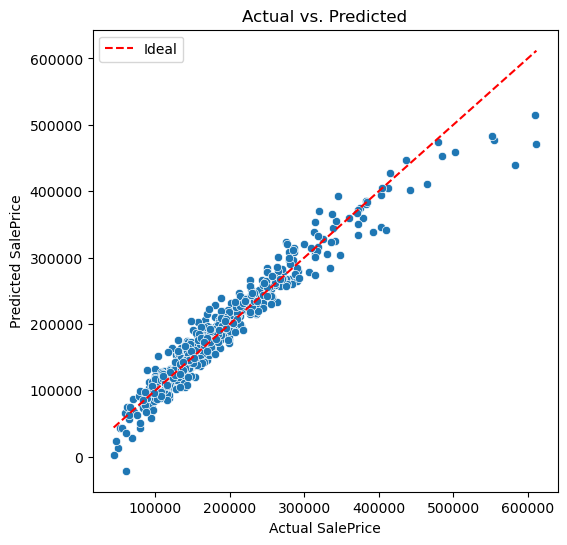

{'MSE': 444128687.9323718, 'RMSE': 21074.360913972498, 'MAE': 14981.097008547009, 'R2': 0.9375330774583797}


In [12]:
def evaluate_deployed_model(predictor, X_val, y_val, batch_size=200):
    """
    Evaluate the deployed Linear Learner model on the validation set.

    This function performs batch inference on the validation data, computes regression
    metrics (MSE, RMSE, MAE, and R²), and displays visualizations including a scatter plot
    (Actual vs. Predicted) and a residual distribution plot.

    Interpretation of Outputs:
      - MSE (Mean Squared Error): Indicates the average squared difference between predicted
        and actual values. Lower values imply better model performance and penalize larger errors.
      - RMSE (Root Mean Squared Error): Provides an estimate of the standard deviation of the
        prediction errors, in the same units as the target variable. Lower values are better.
      - MAE (Mean Absolute Error): Represents the average absolute difference between predictions
        and actual values. Lower values mean smaller errors on average.
      - R² (Coefficient of Determination): Ranges from negative values to 1.0. Values closer to 1.0
        indicate that the model explains a large portion of the variance in the target variable.
        A negative value suggests that the model performs worse than a simple mean-based prediction.

    Additionally, the function displays:
      - A scatter plot of Actual vs. Predicted values, where the ideal outcome is for the points
        to lie close to the red dashed identity line.
      - A histogram of residuals (Actual - Predicted) with a KDE curve, which helps assess if the
        errors are approximately normally distributed and centered around zero.

    Parameters:
        predictor: The SageMaker Predictor object for the deployed model.
        X_val (pd.DataFrame): Validation features.
        y_val (pd.Series): True target values.
        batch_size (int, optional): Number of samples to process per inference batch. Defaults to 200.

    Returns:
        dict: A dictionary containing the evaluation metrics.
    """


    # Convert validation data to NumPy arrays.
    X_array = X_val.values
    y_array = y_val.values

    all_predictions = []

    # Batch inference to avoid large payload issues.
    for start_i in range(0, len(X_array), batch_size):
        end_i = min(start_i + batch_size, len(X_array))
        batch_data = X_array[start_i:end_i]

        # Make a prediction for the current batch.
        response = predictor.predict(batch_data)
        # Extract the predicted 'score' values.
        batch_preds = [float(item.get("score", 0.0))
                       for item in response.get("predictions", [])]
        all_predictions.extend(batch_preds)

    # Convert all predictions to a NumPy array.
    all_predictions = np.array(all_predictions)

    # Calculate regression metrics.
    mse_val = mean_squared_error(y_array, all_predictions)
    rmse_val = np.sqrt(mse_val)
    mae_val = mean_absolute_error(y_array, all_predictions)
    r2_val = r2_score(y_array, all_predictions)

    # Display metrics.
    print("\nEvaluation on Validation Set:")
    print(f"  MSE:   {mse_val:.4f}")
    print(f"  RMSE:  {rmse_val:.4f}")
    print(f"  MAE:   {mae_val:.4f}")
    print(f"  R²:    {r2_val:.4f}\n")

    # Detailed interpretation of the metrics.
    print("Interpretation of Metrics:")
    print(" - MSE (Mean Squared Error): Lower values indicate better performance; this metric penalizes larger errors more heavily.")
    print(" - RMSE (Root Mean Squared Error): Indicates the typical magnitude of errors in the same units as the target variable.")
    print(" - MAE (Mean Absolute Error): Shows the average absolute error; lower values mean the predictions are closer to the actual values.")
    print(" - R² (Coefficient of Determination): Values closer to 1 suggest that a larger proportion of the variance is explained by the model.")
    print("   Values less than 0 indicate the model is performing poorly.\n")

    # Visualization 1: Actual vs. Predicted scatter plot.
    plt.figure(figsize=(6, 6))
    sns.scatterplot(x=y_array, y=all_predictions)
    plt.xlabel("Actual SalePrice")
    plt.ylabel("Predicted SalePrice")
    plt.title("Actual vs. Predicted")
    plt.plot([min(y_array), max(y_array)], [min(y_array), max(y_array)], 'r--', label='Ideal')
    plt.legend()
    plt.show()

    return {
        "MSE": mse_val,
        "RMSE": rmse_val,
        "MAE": mae_val,
        "R2": r2_val
    }

metrics = evaluate_deployed_model(predictor, X_val, y_val)
print(metrics)


# STEP 9: QUERY THE DEPLOYED ENDPOINT WITH TEST DATA

In [13]:
"""
Module: Model Prediction and Evaluation for Regression using SageMaker Predictor

This module shows how to obtain regression predictions from a deployed SageMaker predictor.
It selects the first 5 rows from the validation set, sends them to the endpoint in CSV format,
extracts the predicted numeric values, and compares them with the actual target values.
"""

# Select the first 5 rows from the validation set for evaluation.
sample_data = X_val.head(5)

# Convert the selected data to a NumPy array.
# This format is required by the predictor's CSVSerializer.
input_data = sample_data.values

# Request predictions from the deployed endpoint using the sample data.
# The predictor sends the input as CSV and returns predictions.
predictions = predictor.predict(input_data)

# Extract the predicted scores from the response.
# The response is expected to include a "predictions" key with each result containing a "score" field.
if "predictions" in predictions:
    y_pred_test = [float(result["score"]) for result in predictions["predictions"]]
    print("\nTest Predictions on 5 samples:", y_pred_test)
else:
    print("No 'predictions' key found in the response:", predictions)

# Retrieve the actual target values for the selected sample data.
sample_targets = y_val.loc[sample_data.index]
print("Actual:", sample_targets.tolist())



Test Predictions on 5 samples: [127534.5, 447422.75, 200611.0, 214723.5, 141856.0]
Actual: [143000, 437154, 205950, 235000, 138000]


# STEP 10: DELETE THE ENDPOINT AND ENDPOINT CONFIG (OPTIONAL CLEANUP)

In [14]:
"""
Module: SageMaker Endpoint and Configuration Deletion

This module defines a function to delete a SageMaker endpoint and its corresponding endpoint configuration.
It first attempts to describe each resource to verify its existence, then deletes it if found.
If a resource is not found, it prints a message indicating so and continues without raising an error.
"""

def delete_sagemaker_endpoint_and_config(sm_client, endpoint_name, endpoint_config_name):
    """
    Delete a SageMaker endpoint and its configuration if they exist.

    Parameters:
        sm_client: Boto3 client for SageMaker.
        endpoint_name (str): The name of the endpoint to delete.
        endpoint_config_name (str): The name of the endpoint configuration to delete.
    """
    # Delete the endpoint.
    try:
        # Attempt to describe the endpoint to check if it exists.
        sm_client.describe_endpoint(EndpointName=endpoint_name)
        # If no exception, proceed to delete the endpoint.
        sm_client.delete_endpoint(EndpointName=endpoint_name)
        print(f"Deleted endpoint: {endpoint_name}")
    except sm_client.exceptions.ClientError as e:
        # If the endpoint is not found, inform the user and continue.
        if "Could not find endpoint" in str(e) or "ResourceNotFound" in str(e):
            print(f"Endpoint '{endpoint_name}' does not exist.")
        else:
            raise e

    # Delete the endpoint configuration.
    try:
        # Attempt to describe the endpoint configuration to check if it exists.
        sm_client.describe_endpoint_config(EndpointConfigName=endpoint_config_name)
        # If no exception, proceed to delete the endpoint configuration.
        sm_client.delete_endpoint_config(EndpointConfigName=endpoint_config_name)
        print(f"Deleted endpoint config: {endpoint_config_name}")
    except sm_client.exceptions.ClientError as e:
        # If the endpoint configuration is not found, inform the user and continue.
        if "Could not find endpoint configuration" in str(e) or "ResourceNotFound" in str(e):
            print(f"Endpoint config '{endpoint_config_name}' does not exist.")
        else:
            raise e

# Automatically delete the endpoint and its configuration.
#delete_sagemaker_endpoint_and_config(sm_client, endpoint_name, endpoint_config_name)
